In [ ]:
import numpy as np
import pands as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Download Images with sentinal API :



### Create a csv file for the Shape :


In [ ]:
pip install fiona

In [ ]:
import fiona

In [ ]:
  data = [[
        -88.4070031,
        40.1126533
      ,'Border1'],
      [
        -88.3886353,
        40.1126533,
       'Border1'
      ],
      [
        -88.3879487,
        40.0984732,
       'Border1'
      ],
      [
        -88.4072606,
        40.0983419,
       'Border1'
      ],
      [
        -88.4070889,
        40.1127189,
       'Border1'
      ],
      [
        -88.4070031,
        40.1127189,
       'Border1'
      ],
      [
        -88.4070031,
        40.1126533
      ,'Border1'
      ]]
      

In [ ]:
data =pd.DataFrame(data, columns=['X','Y','Name'])
data.head()

In [ ]:
data.to_csv(r'/content/drive/MyDrive/test/Poly.csv', index = False)

### Convert the csv file to .shp file :

In [ ]:
polyDf = pd.read_csv('/content/drive/MyDrive/test/Poly.csv',header=0)
polyDf.head()

In [ ]:
schema = {
    'geometry':'Polygon',
    'properties':[('Name','str')]
}

polygonShp = fiona.open('/content/drive/MyDrive/test/Polygon.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:4326")

In [ ]:
xyList = []
rowName = ''
for index, row in polyDf.iterrows():
    xyList.append((row.X,row.Y))
    rowName = row.Name
xyList[:5]

In [ ]:
#save record and close shapefile
rowDict = {
'geometry' : {'type':'Polygon',
                 'coordinates': [xyList]}, #Here the xyList is in brackets
'properties': {'Name' : rowName},
}
polygonShp.write(rowDict)
#close fiona object
polygonShp.close()

### filter data with .shp file :

In [ ]:
pip install sentinelsat

In [ ]:
pip install rasterio

In [ ]:
pip install geopandas

In [ ]:
## Requirements :

import rasterio as rio
import geopandas as gpd
from sentinelsat import SentinelAPI
import folium 
from shapely.geometry import MultiPolygon, Polygon


In [ ]:
## Connect to the API :

user = 'zakaryajouhafa' 
password = 'buxwAx-dakvo9-rotqah' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [ ]:
## Read the Shapefile :

nReserve = gpd.read_file('/content/drive/MyDrive/test/Polygon.shp')

m = folium.Map([41.7023292727353, 12.34697305914639], zoom_start=12)
folium.GeoJson(nReserve).add_to(m)
m

In [ ]:
footprint = None
for i in nReserve['geometry']:
    footprint = i

In [ ]:
## Choose the image collection : 

products = api.query(footprint,
                     date = ('20190601', '20190626'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [ ]:
## Sort data :

products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,cloudcoverpercentage,highprobacloudspercentage,mediumprobacloudspercentage,notvegetatedpercentage,snowicepercentage,unclassifiedpercentage,vegetationpercentage,waterpercentage,format,instrumentshortname,instrumentname,s2datatakeid,platformidentifier,orbitdirection,platformserialidentifier,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
89a3abe7-4368-4746-a7db-4adb54403579,S2B_MSIL2A_20190625T163849_N0212_R126_T16TCK_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T16:38:49.024Z, Instrument: MS...",false,2019-06-25 16:38:49.024,2019-06-25 16:38:49.024,2019-06-26 02:58:15.974,12021,126,0.119067,0.070431,0.048414,50.427634,0.000199,0.128331,48.554826,0.329004,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190625T163849_012021_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,1.07 GB,S2B_MSIL2A_20190625T163849_N0212_R126_T16TCK_2...,S2B_OPER_MSI_L1C_TL_SGS__20190625T201857_A0120...,S2B_MSIL2A_20190625T163849_N0212_R126_T16TCK_2...,89a3abe7-4368-4746-a7db-4adb54403579,"MULTIPOLYGON (((-89.33066 39.63822, -88.05145 ..."
35979085-f805-4698-ac3c-02afa2e4973f,S2A_MSIL2A_20190610T163901_N0212_R126_T16TCK_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-10T16:39:01.024Z, Instrument: MS...",false,2019-06-10 16:39:01.024,2019-06-10 16:39:01.024,2019-06-11 04:59:12.350,20715,126,0.267557,0.026924,0.016948,81.148356,0.000249,0.086453,18.017305,0.306429,SAFE,MSI,Multi-Spectral Instrument,GS2A_20190610T163901_020715_N02.12,2015-028A,DESCENDING,Sentinel-2A,02.12,Level-2A,S2MSI2A,Sentinel-2,1.07 GB,S2A_MSIL2A_20190610T163901_N0212_R126_T16TCK_2...,S2A_OPER_MSI_L1C_TL_MTI__20190610T200713_A0207...,S2A_MSIL2A_20190610T163901_N0212_R126_T16TCK_2...,35979085-f805-4698-ac3c-02afa2e4973f,"MULTIPOLYGON (((-89.33066 39.63822, -88.05145 ..."


In [ ]:
## Downllload the data : 

api.download_all(products_gdf_sorted.index)

ResultTuple(downloaded={}, retrieval_triggered={'89a3abe7-4368-4746-a7db-4adb54403579': {'id': '89a3abe7-4368-4746-a7db-4adb54403579', 'title': 'S2B_MSIL2A_20190625T163849_N0212_R126_T16TCK_20190625T210047', 'size': 1147215815, 'md5': '72A62D83214DD0590B1837A1D8BD6F5D', 'date': datetime.datetime(2019, 6, 25, 16, 38, 49, 24000), 'footprint': 'POLYGON((-89.364685 40.62663972727231,-88.0668 40.645928490590144,-88.05145 39.656847486720984,-89.33066 39.638218234831534,-89.364685 40.62663972727231))', 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('89a3abe7-4368-4746-a7db-4adb54403579')/$value", 'Online': False, 'Creation Date': datetime.datetime(2019, 6, 26, 3, 0, 9, 118000), 'Ingestion Date': datetime.datetime(2019, 6, 26, 2, 58, 15, 974000), 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('89a3abe7-4368-4746-a7db-4adb54403579')/Products('Quicklook')/$value"}}, failed={'35979085-f805-4698-ac3c-02afa2e4973f': {'id': '35979085-f805-4698-ac3c-02afa2e4973f', 

## Images vizualisation :

In [ ]:
from rasterio.plot import show
from rasterio.mask import mask

In [ ]:
R10 = '/content/drive/MyDrive/S2B_MSIL2A_20190625T163849_N0212_R126_T16TCK_20190625T210047.SAFE/GRANULE/L2A_T16TCK_A012021_20190625T164413/IMG_DATA/R60m'
b4 = rio.open(R10+'/T16TCK_20190625T163849_B04_60m.jp2')
b3 = rio.open(R10+'/T16TCK_20190625T163849_B03_60m.jp2')
b2 = rio.open(R10+'/T16TCK_20190625T163849_B02_60m.jp2')


# Create an RGB image 
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

In [ ]:
b2.width * b2.height #R10m

120560400

In [ ]:
b2.width * b2.height #R60m

3348900

In [ ]:
# Open b4 and b8
b8a = rio.open(R10+'/T16TCK_20190625T163849_B8A_60m.jp2')
b11 = rio.open(R10+'/T16TCK_20190625T163849_B11_60m.jp2')

# read Red(b4) and NIR(b8) as arrays
shortinfra = b11.read()
nir = b8a.read()

# Calculate ndvi
MDVI = (nir.astype(float)-shortinfra.astype(float))/(nir+shortinfra)

# Write the MDVI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

with rio.open('MDVI.tif', 'w', **meta) as dst:
    dst.write(MDVI.astype(rio.float32))

In [ ]:
# Open b4 and b8
b8 = rio.open('/content/drive/MyDrive/S2B_MSIL2A_20190625T163849_N0212_R126_T16TCK_20190625T210047.SAFE/GRANULE/L2A_T16TCK_A012021_20190625T164413/IMG_DATA/R10m/T16TCK_20190625T163849_B08_10m.jp2')

# read Red(b4) and NIR(b8) as arrays
shortinfra = b11.read()
nir = b8.read()

# Calculate ndvi
NDWI = (nir.astype(float)-shortinfra.astype(float))/(nir+shortinfra)

# Write the NDWI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

with rio.open('NDWI.tif', 'w', **meta) as dst:
    dst.write(NDWI.astype(rio.float32))

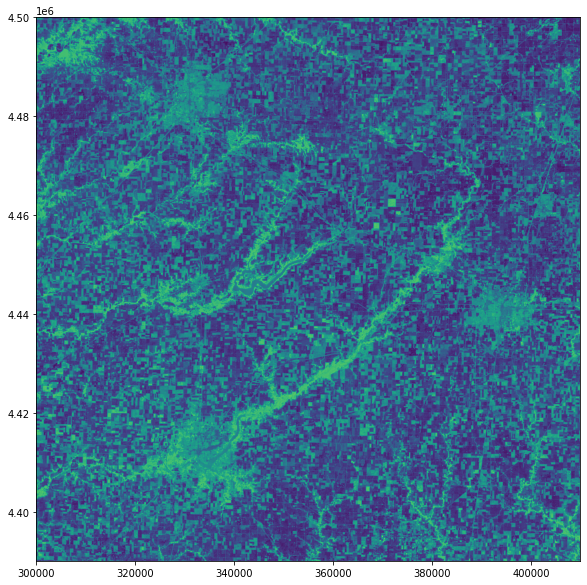

In [ ]:
src3 = rio.open('/content/MDVI.tif')
fig, ax = plt.subplots(1, figsize=(12, 10))
show(src3, ax=ax)
plt.show()

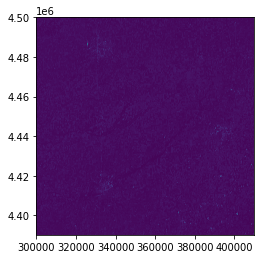

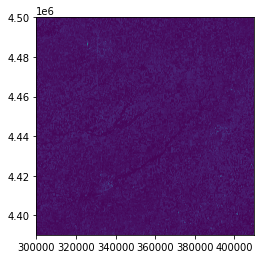

(<matplotlib.axes._subplots.AxesSubplot at 0x7f9d13169d10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d130d7110>)

In [ ]:
show(b2), show(b4)

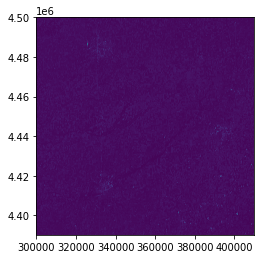

In [ ]:
src = rio.open("RGB.tiff") 
show(src)

In [ ]:
nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})

with rio.open("RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.7/dist-packages/rasterio/mask.py:88: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


In [ ]:
src1 = rio.open('RGB_masked.tif')
show(src1)

In [ ]:
# Open b4 and b8
b4 = rio.open(R10+'/T16TCK_20190625T163849_B04_10m.jp2')
b8 = rio.open(R10+'/T16TCK_20190625T163849_B08_10m.jp2')

# read Red(b4) and NIR(b8) as arrays
red = b4.read()
nir = b8.read()

# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

# Write the NDVI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

with rio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rio.float32))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


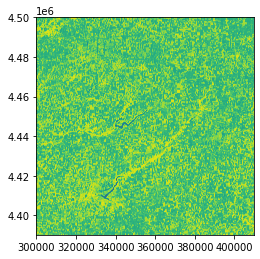

In [ ]:
src2 = rio.open('NDVI.tif')
show(src2)